# Titanic Survival Prediction

Guide relating to this notebook can be found here:

[https://simplesteps.guide/guides/technology/machine-learning-ai/end-to-end-machine-learning-titanic-survival-prediction/introduction](https://simplesteps.guide/guides/technology/machine-learning-ai/end-to-end-machine-learning-titanic-survival-prediction/introduction)

### Import the libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    roc_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

sns.set(style="whitegrid")
RANDOM_STATE = 42

# Load dataset
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


---

### Exploratory Data Analysis (EDA)

##### Overall survival rate

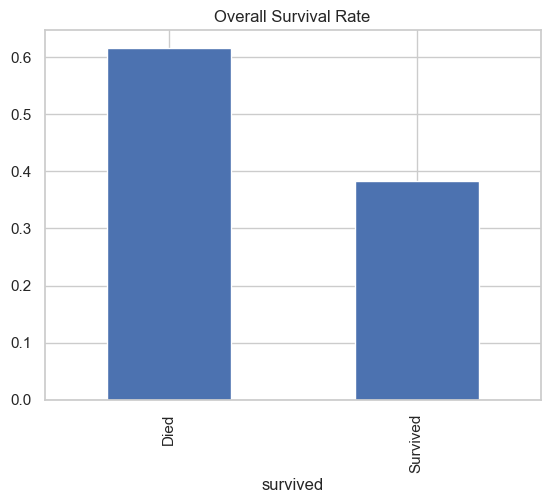

In [2]:
titanic["survived"].value_counts(normalize=True).plot(kind="bar")
plt.title("Overall Survival Rate")
plt.xticks([0, 1], ["Died", "Survived"])
plt.show()


##### Survival by gender


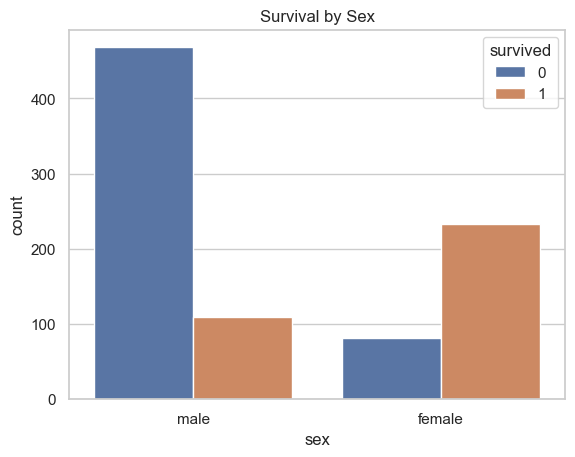

In [3]:
sns.countplot(data=titanic, x="sex", hue="survived")
plt.title("Survival by Sex")
plt.show()


##### Survival by class

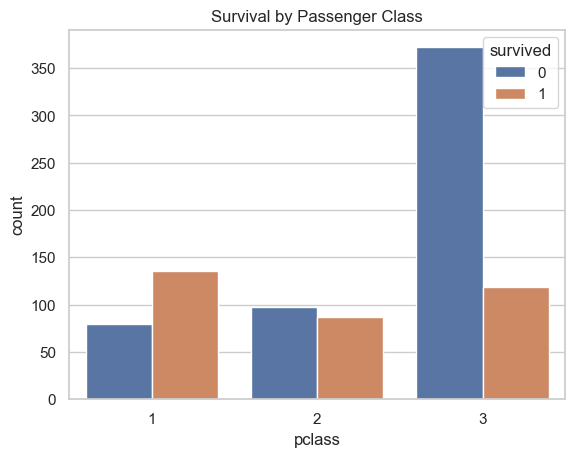

In [4]:
sns.countplot(data=titanic, x="pclass", hue="survived")
plt.title("Survival by Passenger Class")
plt.show()


##### Age distribution

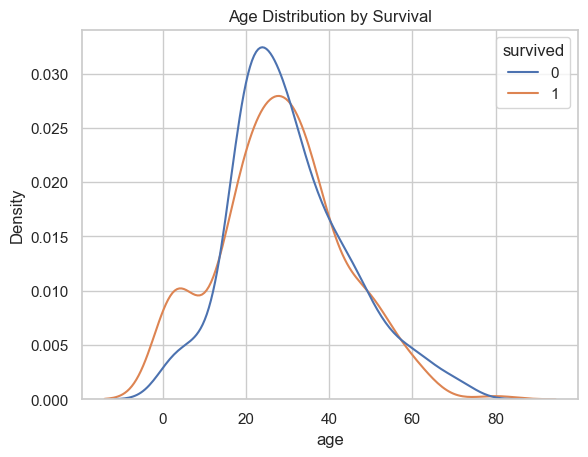

In [5]:
sns.kdeplot(data=titanic, x="age", hue="survived", common_norm=False)
plt.title("Age Distribution by Survival")
plt.show()


##### Look specifically at children

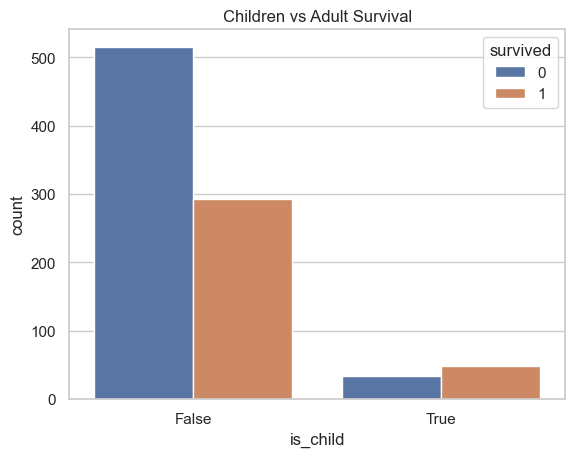

In [6]:
titanic["is_child"] = titanic["age"] < 16
sns.countplot(data=titanic, x="is_child", hue="survived")
plt.title("Children vs Adult Survival")
plt.show()

---

### Correlations Among Numeric Features

##### Correlation matrix

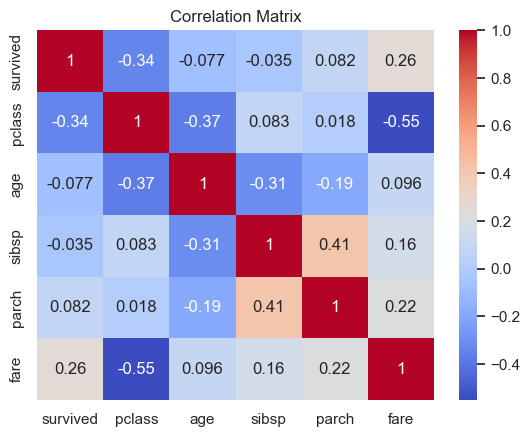

In [7]:
numeric_cols = ["survived", "pclass", "age", "sibsp", "parch", "fare"]
sns.heatmap(titanic[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

---

### Statistical Hypothesis Testing (SciPy)

##### Women vs Men survival (chi-square test)

In [8]:
ct = pd.crosstab(titanic["sex"], titanic["survived"])
chi2, p, _, _ = stats.chi2_contingency(ct)
print("Sex vs Survival:", p)

Sex vs Survival: 1.197357062775565e-58


##### Adult VS Children survival

In [9]:
titanic["is_child"] = titanic["age"] < 16
ct = pd.crosstab(titanic["is_child"], titanic["survived"])
chi2, p, _, _ = stats.chi2_contingency(ct)
print("Children vs Adults:", p)

Children vs Adults: 8.005497211300109e-05


##### Passenger class

In [10]:
ct = pd.crosstab(titanic["pclass"], titanic["survived"])
chi2, p, _, _ = stats.chi2_contingency(ct)
print("Class vs Survival:", p)

Class vs Survival: 4.549251711298793e-23


##### Age differences (t-test)

In [11]:
age_data = titanic[["survived", "age"]].dropna()
died = age_data[age_data["survived"]==0]["age"]
surv = age_data[age_data["survived"]==1]["age"]

t, p = stats.ttest_ind(died, surv, equal_var=False)
print("Age difference:", p)

Age difference: 0.04118965162586638


---

### Preparing Data for Machine Learning (ETL)

##### Define the features list

In [12]:
features = [
    "pclass", "sex", "age", "sibsp", "parch",
    "fare", "embarked", "class", "who", "alone"
]

target = "survived"

data = titanic[features + [target]].copy()
data["age"] = data["age"].fillna(data["age"].median())
data["fare"] = data["fare"].fillna(data["fare"].median())
data["embarked"] = data["embarked"].fillna(data["embarked"].mode()[0])

##### Split the data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42, stratify=data[target]
)

##### Define numeric and categorical transformers:

In [14]:
numeric_features = ["age", "sibsp", "parch", "fare", "pclass"]
categorical_features = ["sex", "embarked", "class", "who", "alone"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

---

### Scikit-Learn Models

##### Logistic Regression

In [15]:
log_reg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

pred_lr = log_reg.predict(X_test)
prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print("LogReg ROC-AUC:", roc_auc_score(y_test, prob_lr))

LogReg Accuracy: 0.8324022346368715
LogReg ROC-AUC: 0.8699604743083004


##### Chart of logisitc regression

/Users/petersmith/Documents/python/TitanicSurvivalPrediction/.venv/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


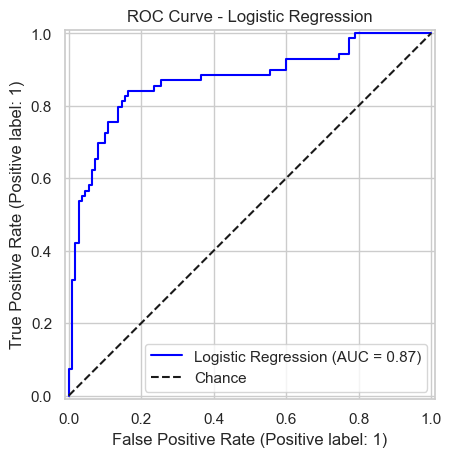

In [16]:
RocCurveDisplay.from_predictions(
    y_test,
    prob_lr,
    name="Logistic Regression",
    color="blue"
)

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

##### Confusion Matrix Heatmap - Logestic regression

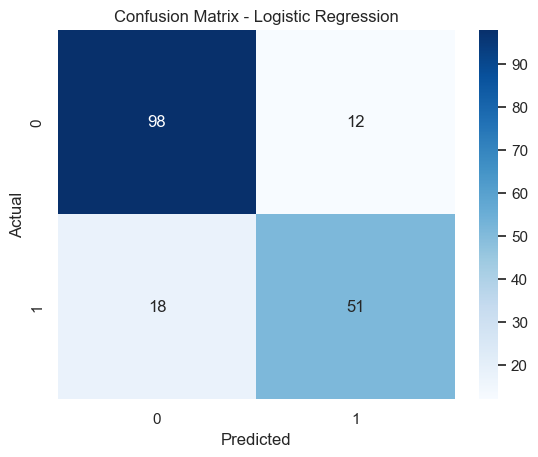

In [17]:
cm = confusion_matrix(y_test, pred_lr)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


##### Random forrest

In [18]:
rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
prob_rf = rf.predict_proba(X_test)[:,1]

print("RandomForest Accuracy:", accuracy_score(y_test, pred_rf))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, prob_rf))

RandomForest Accuracy: 0.8212290502793296
RandomForest ROC-AUC: 0.8373517786561265


##### Plot a ROC Curve for Random Forrest

/Users/petersmith/Documents/python/TitanicSurvivalPrediction/.venv/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


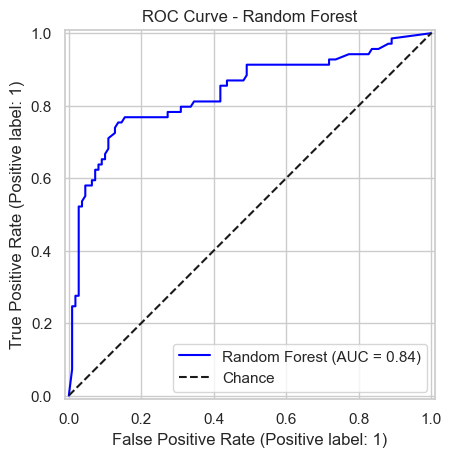

In [19]:
RocCurveDisplay.from_predictions(
    y_test,
    prob_rf,
    name="Random Forest",
    color="blue"
)

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

##### Random forrest confusion matrix

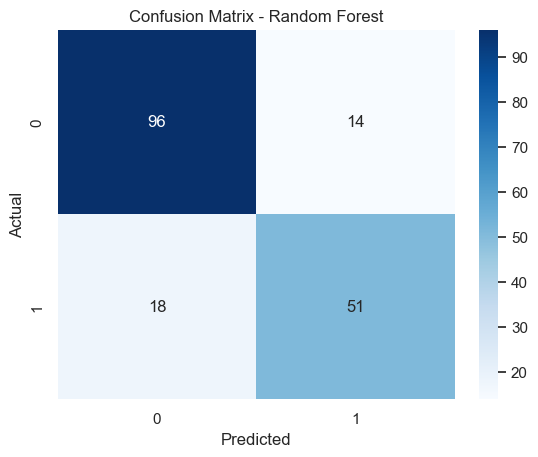

In [20]:
cm = confusion_matrix(y_test, pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

---
### Neural Network (Keras)

##### reuse the fitted preprocessor

In [21]:
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)

if hasattr(X_train_t, "toarray"):
    X_train_t = X_train_t.toarray()
    X_test_t = X_test_t.toarray()

##### Define a feedforward network

In [22]:
model = models.Sequential([
    layers.Input(shape=(X_train_t.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

##### Train

In [23]:
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.fit(
    X_train_t, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early],
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6028 - loss: 0.6956 - val_accuracy: 0.5944 - val_loss: 0.6246
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6608 - loss: 0.6046 - val_accuracy: 0.7343 - val_loss: 0.5532
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7399 - loss: 0.5398 - val_accuracy: 0.8042 - val_loss: 0.5086
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7786 - loss: 0.5190 - val_accuracy: 0.8252 - val_loss: 0.4768
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 0.4858 - val_accuracy: 0.8322 - val_loss: 0.4563
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7979 - loss: 0.4663 - val_accuracy: 0.8322 - val_loss: 0.4462
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8120 - loss: 0.4398 - val_accuracy: 0.8252 - val_loss: 0.4385
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.4395 - val_accuracy: 0.8462 - val_loss:

##### Evaluate

In [24]:
prob_keras = model.predict(X_test_t).ravel()
pred_keras = (prob_keras >= 0.5).astype(int)

print("Keras Accuracy:", accuracy_score(y_test, pred_keras))
print("Keras ROC-AUC:", roc_auc_score(y_test, prob_keras))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Keras Accuracy: 0.8156424581005587
Keras ROC-AUC: 0.8628458498023713


---

### Model Comparison & Conclusion

##### Metrics side by side

In [25]:
print("=== Model Comparison ===")
print("Logistic Regression  - Acc: %.3f, AUC: %.3f" % (accuracy_score(y_test, pred_lr), roc_auc_score(y_test, prob_lr)))
print("Random Forest        - Acc: %.3f, AUC: %.3f" % (accuracy_score(y_test, pred_rf), roc_auc_score(y_test, prob_rf)))
print("Keras Neural Network - Acc: %.3f, AUC: %.3f" % (accuracy_score(y_test, pred_keras), roc_auc_score(y_test, prob_keras)))

=== Model Comparison ===
Logistic Regression  - Acc: 0.832, AUC: 0.870
Random Forest        - Acc: 0.821, AUC: 0.837
Keras Neural Network - Acc: 0.816, AUC: 0.863


##### Overall ROC curves

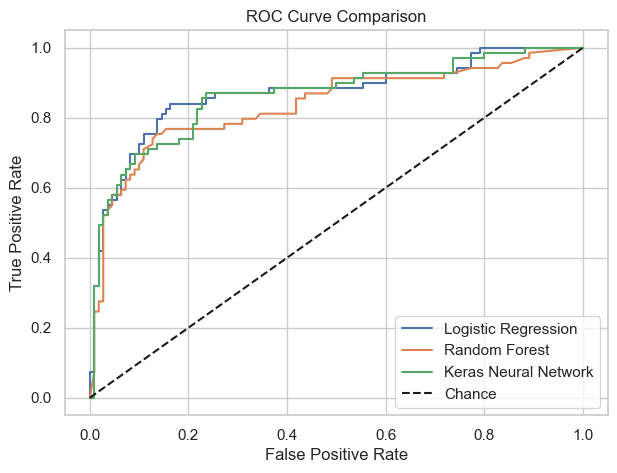

In [26]:
plt.figure(figsize=(7, 5))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, prob_lr)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

# Keras
fpr_k, tpr_k, _ = roc_curve(y_test, prob_keras)
plt.plot(fpr_k, tpr_k, label="Keras Neural Network")

plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

---

### Predictions

##### Create random test passengers

In [27]:
# Example passengers to predict
sample_passengers = pd.DataFrame([
    {
        "pclass": 1,
        "sex": "female",
        "age": 25,
        "sibsp": 0,
        "parch": 0,
        "fare": 100,
        "embarked": "S",
        "class": "First",
        "who": "woman",
        "alone": True
    },
    {
        "pclass": 3,
        "sex": "male",
        "age": 35,
        "sibsp": 1,
        "parch": 3,
        "fare": 12,
        "embarked": "S",
        "class": "Third",
        "who": "man",
        "alone": False
    }
])

sample_passengers

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,alone
0,1,female,25,0,0,100,S,First,woman,True
1,3,male,35,1,3,12,S,Third,man,False


##### Prediction with logistic regression

In [28]:
pred_lr = log_reg.predict(sample_passengers)
prob_lr = log_reg.predict_proba(sample_passengers)[:, 1]

print("Logistic Regression Predictions:", pred_lr)
print("Logistic Regression Probabilities:", prob_lr)

Logistic Regression Predictions: [1 0]
Logistic Regression Probabilities: [0.94124233 0.0275436 ]


##### Predictions with Random Forest

In [29]:
pred_rf = rf.predict(sample_passengers)
prob_rf = rf.predict_proba(sample_passengers)[:, 1]

print("Random Forest Predictions:", pred_rf)
print("Random Forest Probabilities:", prob_rf)

Random Forest Predictions: [1 0]
Random Forest Probabilities: [0.995 0.015]


##### Predictions with the Keras Neural Network

In [30]:
sample_processed = preprocessor.transform(sample_passengers)

# Convert sparse matrix if needed
if hasattr(sample_processed, "toarray"):
    sample_processed = sample_processed.toarray()

prob_keras = model.predict(sample_processed).ravel()
pred_keras = (prob_keras >= 0.5).astype(int)

print("Keras Predictions:", pred_keras)
print("Keras Probabilities:", prob_keras)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Keras Predictions: [1 0]
Keras Probabilities: [0.9377695  0.07097136]


##### Combined output

In [31]:
results = pd.DataFrame({
    "Passenger": ["A (1st class woman)", "B (3rd class man)"],
    "LR_Prob": prob_lr,
    "LR_Pred": pred_lr,
    "RF_Prob": prob_rf,
    "RF_Pred": pred_rf,
    "Keras_Prob": prob_keras,
    "Keras_Pred": pred_keras
})

print(results)

             Passenger   LR_Prob  LR_Pred  RF_Prob  RF_Pred  Keras_Prob  \
0  A (1st class woman)  0.941242        1    0.995        1    0.937769   
1    B (3rd class man)  0.027544        0    0.015        0    0.070971   

   Keras_Pred  
0           1  
1           0  
